In [1]:
import pickle

In [2]:
with open('../data/ner_train.pkl', 'rb') as f:
    corpus_train = pickle.load(f)
    
with open('../data/ner_test.pkl', 'rb') as f:
    corpus_test = pickle.load(f)

In [3]:
train_inputs = []
train_targets = []

for sentence_tag_pairs in corpus_train:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    train_inputs.append(tokens)
    train_targets.append(target)

In [4]:
test_inputs = []
test_targets = []

for sentence_tag_pairs in corpus_test:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    test_inputs.append(tokens)
    test_targets.append(target)

In [5]:
import numpy
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [6]:
# Convert sentence to seq
MAX_VOCAB_SIZE = None

should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK' # otherwise unknown tokens will be removed and len(input) != len(target)
)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [7]:
word2idx = word_tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

Found 23299 unique tokens.


In [8]:
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened

In [9]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [10]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [11]:
all_train_targets == all_test_targets

True

In [12]:
# Convert targets to sequences (ints)
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [13]:
# Find max doc length before padding
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [14]:
# Padding
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print(f'Shape of data train tensor: {train_inputs_int.shape}')

Shape of data train tensor: (12733, 113)


In [15]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print(f'Shape of data test tensor: {test_inputs_int.shape}')

Shape of data test tensor: (2970, 113)


In [16]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print(f'Shape of train targets tensor: {train_targets_int.shape}')

Shape of train targets tensor: (12733, 113)


In [17]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print(f'Shape of test targets tensor: {test_targets_int.shape}')

Shape of test targets tensor: (2970, 113)


In [18]:
K = len(tag_tokenizer.word_index) + 1
K

10

In [19]:
D = 32
i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [20]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [21]:
r = model.fit(
    train_inputs_int,
    train_targets_int,
    epochs=5,
    validation_data=(test_inputs_int, test_targets_int)
)

Epoch 1/5


2024-04-21 15:14:08.645075: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-21 15:14:09.741186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-04-21 15:14:10.937778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


398/398 [==============================] - 16s 34ms/step - loss: 0.7278 - accuracy: 0.8372 - val_loss: 0.4893 - val_accuracy: 0.8621
Epoch 2/5
398/398 [==============================] - 12s 31ms/step - loss: 0.3114 - accuracy: 0.9022 - val_loss: 0.3094 - val_accuracy: 0.9206
Epoch 3/5
398/398 [==============================] - 12s 31ms/step - loss: 0.1554 - accuracy: 0.9569 - val_loss: 0.2167 - val_accuracy: 0.9463
Epoch 4/5
398/398 [==============================] - 12s 31ms/step - loss: 0.0746 - accuracy: 0.9827 - val_loss: 0.1899 - val_accuracy: 0.9514
Epoch 5/5
398/398 [==============================] - 13s 32ms/step - loss: 0.0423 - accuracy: 0.9905 - val_loss: 0.1794 - val_accuracy: 0.9536


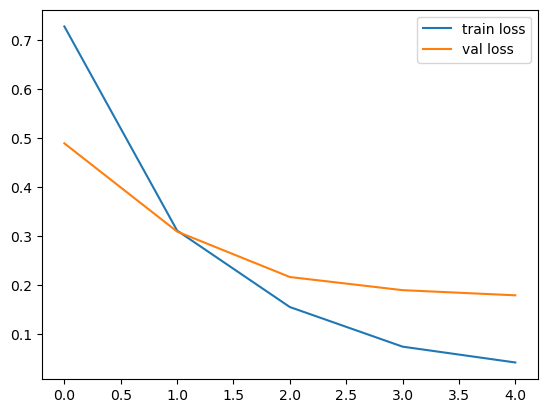

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

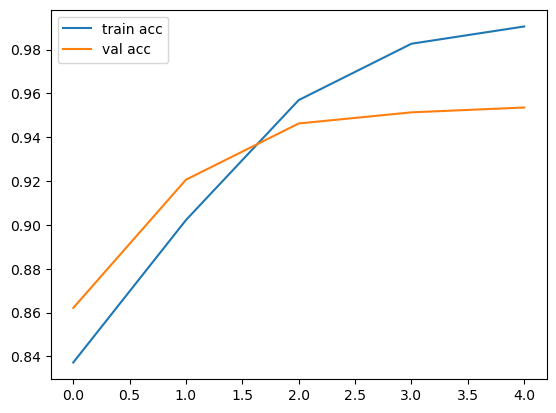

In [23]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [24]:
# True model acc - aboce includes padding
train_lengths = []
for sentence in train_inputs:
    train_lengths.append(len(sentence))
    
test_lengths = []
for sentence in test_inputs:
    test_lengths.append(len(sentence))

In [25]:
import numpy as np

In [26]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
    # probs is T x K
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    train_predictions.append(preds)
    
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

398/398 [==============================] - 3s 6ms/step


In [27]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
    # probs is T x K
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    test_predictions.append(preds)
    
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

93/93 [==============================] - 1s 6ms/step


In [28]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

Train acc: 0.9940303403849212
Test acc: 0.9535588484168683


In [29]:
print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train f1: 0.9586232004833717
Test f1: 0.8043322430449528
